### 1 Load and Understand the data sets

In [18]:
# Importhing important Libraries 
import sys
import os
sys.path.append(os.path.abspath(".."))
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

#### 1.1 Load the dataset

In [10]:
#1. Load the dataset
fraud_df = pd.read_csv("../data/Fraud_Data.csv")
ip_df = pd.read_csv("../data/IpAddress_to_Country.csv")
credit_df = pd.read_csv("../data/creditcard.csv")

#### 1.2 understand the data

In [11]:
#2.  Understanding the data
fraud_df.head(), ip_df.head(), credit_df.head()

(   user_id          signup_time        purchase_time  purchase_value  \
 0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
 1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
 2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
 3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
 4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   
 
        device_id source browser sex  age    ip_address  class  
 0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
 1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
 2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
 3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
 4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  ,
    lower_bound_ip_address  upper_bound_ip_address    country
 0              16777216.0                16777471  Australia
 1              16777472.0                167

#### 1.3 Explore Missing Value

In [12]:
#3. Explore missing values
print("Fraud Data:\n", fraud_df.isnull().sum())
print("\nCredit Card Data:\n", credit_df.isnull().sum())
print("\nIP to Country Data:\n", ip_df.isnull().sum())

Fraud Data:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Credit Card Data:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

IP to Country Data:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64


### 2. Data Cleaning

In [16]:
#4. Data Cleaning
# Clean and convert datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'], errors='coerce')
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'], errors='coerce')

# Drop rows with failed datetime parsing
fraud_df.dropna(subset=['signup_time', 'purchase_time'], inplace=True)

# Drop duplicates
fraud_df.drop_duplicates(inplace=True)
ip_df.drop_duplicates(inplace=True)
credit_df.drop_duplicates(inplace=True)

# Save cleaned datasets
fraud_df.to_csv('../data/cleaned_fraud_data.csv', index=False)
ip_df.to_csv('../data/cleaned_ip_data.csv', index=False)
credit_df.to_csv('../data/cleaned_creditcard_data.csv', index=False)


### 3. EDA Univariate and Bivariate Aanlysis

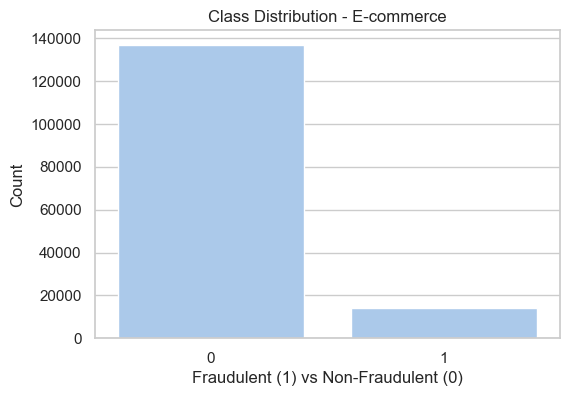

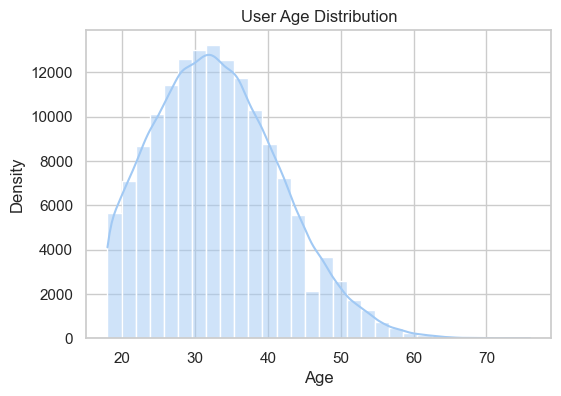

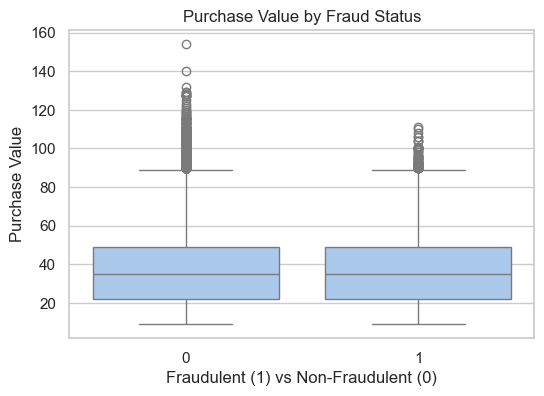

In [19]:
# 📥 Load cleaned data

# Load cleaned fraud dataset
fraud_df = pd.read_csv("../data/cleaned_fraud_data.csv", parse_dates=['signup_time', 'purchase_time'])

# 🧼 Optional: Ensure datetime format if not already parsed
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'], errors='coerce')
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'], errors='coerce')

# Set Seaborn style
sns.set(style="whitegrid", palette="pastel")

# 📊 Class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=fraud_df, x='class')
plt.title("Class Distribution - E-commerce")
plt.xlabel("Fraudulent (1) vs Non-Fraudulent (0)")
plt.ylabel("Count")
plt.show()

# 🧑 Age distribution
plt.figure(figsize=(6,4))
sns.histplot(data=fraud_df, x='age', kde=True, bins=30)
plt.title("User Age Distribution")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

# 💰 Purchase value vs class (Bivariate)
plt.figure(figsize=(6,4))
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title("Purchase Value by Fraud Status")
plt.xlabel("Fraudulent (1) vs Non-Fraudulent (0)")
plt.ylabel("Purchase Value")
plt.show()


### 4. Merge Datasets for Geolocation Analysis


#### 4.1 Convert IP addresses to integer format


In [20]:
# Load cleaned datasets
fraud_df = pd.read_csv("../data/cleaned_fraud_data.csv", parse_dates=['signup_time', 'purchase_time'])
ip_df = pd.read_csv("../data/cleaned_ip_data.csv")
# Convert IPs to integers
def ip_to_int(ip_str):
    try:
        return int(ipaddress.IPv4Address(ip_str))
    except:
        return None

fraud_df['ip_int'] = fraud_df['ip_address'].apply(ip_to_int)
ip_df['lower'] = ip_df['lower_bound_ip_address'].apply(ip_to_int)
ip_df['upper'] = ip_df['upper_bound_ip_address'].apply(ip_to_int)


#### 4.2 Merge Fraud_Data.csv with IpAddress_to_Country.csv


In [21]:
# Match IP to country
def find_country(ip_val):
    match = ip_df[(ip_df['lower'] <= ip_val) & (ip_df['upper'] >= ip_val)]
    return match['country'].values[0] if not match.empty else 'Unknown'

tqdm.pandas()
fraud_df['country'] = fraud_df['ip_int'].progress_apply(find_country)

100%|██████████| 151112/151112 [02:28<00:00, 1018.95it/s]


### 5. Feature Engineering

#### 5.1 Transaction frequency and velocity for Fraud_Data.csv


In [23]:
if 'user_id' in fraud_df.columns:
    fraud_df = fraud_df.sort_values(by=['user_id', 'purchase_time'])
    fraud_df['prev_purchase_time'] = fraud_df.groupby('user_id')['purchase_time'].shift(1)
    fraud_df['transaction_velocity'] = (fraud_df['purchase_time'] - fraud_df['prev_purchase_time']).dt.total_seconds()
else:
    fraud_df['transaction_velocity'] = None


#### 5.2 Time-Based features for Fraud_Data.csv
hour_of _day, Day_of_week


In [24]:
# Hour of day
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour

# Day of week
fraud_df['purchase_dayofweek'] = fraud_df['purchase_time'].dt.dayofweek

#### 5.3 time_since_signup: Calculate the duration between signup_time and purchase_time.

In [25]:
# Time since signup
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()


### 6. Data Transformation:

#### 6.1 Handle Class Imbalance

In [35]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (0, 8)
y shape: (0,)


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Select features and target
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']

# Keep numeric only and fill missing values
X = X.select_dtypes(include='number').fillna(X.mean())  # ← updated

# Align and reset index
y = y.loc[X.index]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Sanity check
print("Class counts:\n", y.value_counts())

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE:", pd.Series(y_train_bal).value_counts())


#### 6.2 Normalize / Scale Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale training and test sets separately
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


#### 6.3 Encode Categorical Features

from sklearn.preprocessing import LabelEncoder

categorical_cols = ['browser', 'device', 'country']

for col in categorical_cols:
    le = LabelEncoder()
    fraud_df[col] = le.fit_transform(fraud_df[col].astype(str))


#### Final Data set

In [ ]:
fraud_df.to_csv("../data/fraud_df_engineered.csv", index=False)
